In [ ]:
import os
from collections import OrderedDict
from glob import glob
import pandas as pd
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import yaml
import albumentations as A
from albumentations.core.composition import Compose
from torch.optim import lr_scheduler
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import copy
from torch.profiler import profile, record_function, ProfilerActivity

In [2]:
import archs
import losses
from dataset import Dataset
from metrics import iou_score
from utils import AverageMeter

In [3]:
plt.style.use('default')

print("Librerías importadas correctamente")
print(f"CUDA disponible: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Librerías importadas correctamente
CUDA disponible: True
GPU: NVIDIA GeForce RTX 4060


In [4]:
class LabelSmoothingBCELoss(nn.Module):
  def __init__(self, smoothing=0.05):
    super().__init__()
    self.smoothing = smoothing
      
  def forward(self, pred, target):
    target_smooth = target * (1 - self.smoothing) + 0.5 * self.smoothing
    return F.binary_cross_entropy(pred, target_smooth)

In [5]:
class BinaryDiceLoss(nn.Module):
  def __init__(self, smooth=1.0):
    super().__init__()
    self.smooth = smooth
      
  def forward(self, pred, target):
    pred = pred.view(-1)
    target = target.view(-1)
    
    intersection = (pred * target).sum()
    dice = (2. * intersection + self.smooth) / (pred.sum() + target.sum() + self.smooth)
    
    return 1 - dice

In [6]:
class TverskyLoss(nn.Module):
  def __init__(self, alpha=0.3, beta=0.7, smooth=1):
    super().__init__()
    self.alpha = alpha
    self.beta = beta
    self.smooth = smooth

  def forward(self, pred, target):
    pred = torch.sigmoid(pred)
    pred_flat = pred.view(-1)
    target_flat = target.view(-1)

    TP = (pred_flat * target_flat).sum()
    FP = ((1 - target_flat) * pred_flat).sum()
    FN = (target_flat * (1 - pred_flat)).sum()

    tversky = (TP + self.smooth) / (TP + self.alpha * FP + self.beta * FN + self.smooth)
    return 1 - tversky

In [7]:
class BCEDiceLoss(nn.Module):
  def __init__(self, bce_weight=0.5, dice_weight=0.5, smooth=1.0):
    super().__init__()
    self.bce_weight = bce_weight
    self.dice_weight = dice_weight
    self.bce = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([3.0]))
    self.dice = BinaryDiceLoss(smooth=smooth)
      
  def forward(self, pred, target):
    bce_loss = self.bce(pred, target)
    
    pred_probs = torch.sigmoid(pred)
    dice_loss = self.dice(pred_probs, target)
    
    return self.bce_weight * bce_loss + self.dice_weight * dice_loss

print("Clases de pérdida definidas correctamente")

Clases de pérdida definidas correctamente


In [8]:
class EarlyStopping:
  def __init__(self, patience=10, min_delta=0.001, restore_best_weights=True):
    self.patience = patience
    self.min_delta = min_delta
    self.restore_best_weights = restore_best_weights
    self.best_score = None
    self.counter = 0
    self.best_weights = None
      
  def __call__(self, val_score, model):
    if self.best_score is None:
      self.best_score = val_score
      self.save_checkpoint(model)
    elif val_score < self.best_score + self.min_delta:
      self.counter += 1
      if self.counter >= self.patience:
        if self.restore_best_weights:
          model.load_state_dict(self.best_weights)
        return True
    else:
      self.best_score = val_score
      self.save_checkpoint(model)
      self.counter = 0
    return False
  
  def save_checkpoint(self, model):
    self.best_weights = copy.deepcopy(model.state_dict())

print("Early Stopping definido correctamente")

Early Stopping definido correctamente


In [9]:
config = {
  'name': None,
  'epochs': 100,
  'batch_size': 16,
  
  # Modelo
  'arch': 'NestedUNet',
  'deep_supervision': True,
  'input_channels': 1,
  'input_w': 128,
  'input_h': 128,
  
  # Pérdida
  'loss': 'TverskyLoss',
  
  # Dataset
  'dataset': 'processed_data_512',
  'img_ext': '.png',
  'mask_ext': '.png',
  
  # Optimizador
  'optimizer': 'Adam',
  'lr': 5e-4,
  'momentum': 0.9,
  'weight_decay': 5e-4,
  'nesterov': False,
  
  # Scheduler
  'scheduler': 'CosineAnnealingLR',
  'min_lr': 1e-6,
  'factor': 0.5,
  'patience': 5,
  'milestones': '30,60,90',
  'gamma': 0.5,
  'early_stopping': 10,
  
  # Anti-overfitting
  'dropout_rate': 0.5,
  'label_smoothing': 0.0,
  'validation_split': 0.20,
  'accumulation_steps': 2,
  'multiscale_validation': True,
  
  'num_workers': 4,
}

In [10]:
if config['name'] is None:
  if config['deep_supervision']:
    config['name'] = f"{config['dataset']}_{config['arch']}_binary_wDS"
  else:
    config['name'] = f"{config['dataset']}_{config['arch']}_binary_woDS"

# Directorio para guardar el modelo
os.makedirs(f"models/{config['name']}", exist_ok=True)

In [11]:
print("CONFIGURACIÓN DEL ENTRENAMIENTO:")
print("-" * 50)
for key, value in config.items():
  print(f"{key:25}: {value}")
print("-" * 50)

# Guardar configuración
with open(f"models/{config['name']}/config.yml", 'w') as f:
  yaml.dump(config, f)

print(f"Configuración guardada en models/{config['name']}/config.yml")

CONFIGURACIÓN DEL ENTRENAMIENTO:
--------------------------------------------------
name                     : processed_data_512_NestedUNet_binary_wDS
epochs                   : 100
batch_size               : 16
arch                     : NestedUNet
deep_supervision         : True
input_channels           : 1
input_w                  : 128
input_h                  : 128
loss                     : TverskyLoss
dataset                  : processed_data_512
img_ext                  : .png
mask_ext                 : .png
optimizer                : Adam
lr                       : 0.0005
momentum                 : 0.9
weight_decay             : 0.0005
nesterov                 : False
scheduler                : CosineAnnealingLR
min_lr                   : 1e-06
factor                   : 0.5
patience                 : 5
milestones               : 30,60,90
gamma                    : 0.5
early_stopping           : 10
dropout_rate             : 0.5
label_smoothing          : 0.0
validation_split

In [12]:
if config['loss'] == 'BCELoss':
  if config['label_smoothing'] > 0:
    criterion = LabelSmoothingBCELoss(config['label_smoothing']).cuda()
  else:
    criterion = nn.BCELoss().cuda()
elif config['loss'] == 'BCEDiceLoss':
  criterion = BCEDiceLoss().cuda()
elif config['loss'] == 'BinaryDiceLoss':
  criterion = BinaryDiceLoss().cuda()
elif config['loss'] == 'BCEWithLogitsLoss':
  criterion = nn.BCEWithLogitsLoss().cuda()
elif config['loss'] == 'TverskyLoss':
  criterion = TverskyLoss(alpha=0.7, beta=0.3).cuda()
else:
  criterion = losses.__dict__[config['loss']]().cuda()

cudnn.benchmark = True

In [13]:
print(f"Creando modelo {config['arch']} para segmentación binaria...")

if config['arch'] == 'NestedUNet':
  model = archs.__dict__[config['arch']](
    input_channels=config['input_channels'],
    deep_supervision=config['deep_supervision'],
    dropout_rate=config['dropout_rate']
  )
else:
  model = archs.__dict__[config['arch']](
    num_classes=1,
    input_channels=config['input_channels'],
    deep_supervision=config['deep_supervision']
  )

model = model.cuda()

Creando modelo NestedUNet para segmentación binaria...


In [14]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Modelo creado exitosamente")
print(f"Parámetros totales: {total_params:,}")
print(f"Parámetros entrenables: {trainable_params:,}")
print(f"Memoria estimada: ~{(total_params * 4) / (1024**2):.1f} MB")

Modelo creado exitosamente
Parámetros totales: 9,864,418
Parámetros entrenables: 9,864,418
Memoria estimada: ~37.6 MB


In [15]:
params = filter(lambda p: p.requires_grad, model.parameters())

if config['optimizer'] == 'Adam':
  optimizer = optim.Adam(
    params, lr=config['lr'], weight_decay=config['weight_decay'])
elif config['optimizer'] == 'SGD':
  optimizer = optim.SGD(
    params, lr=config['lr'], momentum=config['momentum'],
    nesterov=config['nesterov'], weight_decay=config['weight_decay'])

In [16]:
if config['scheduler'] == 'CosineAnnealingLR':
  scheduler = lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=config['epochs'], eta_min=config['min_lr'])
elif config['scheduler'] == 'ReduceLROnPlateau':
  scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=config['factor'], 
    patience=config['patience'], min_lr=config['min_lr'])
elif config['scheduler'] == 'MultiStepLR':
  scheduler = lr_scheduler.MultiStepLR(
    optimizer, 
    milestones=[int(e) for e in config['milestones'].split(',')], 
    gamma=config['gamma'])
elif config['scheduler'] == 'ConstantLR':
  scheduler = None

print(f"Optimizador: {config['optimizer']} (LR: {config['lr']})")
print(f"Scheduler: {config['scheduler']}")

Optimizador: Adam (LR: 0.0005)
Scheduler: CosineAnnealingLR


In [17]:
def get_img_ids(subset, config):
  img_path = os.path.normpath(os.path.join('inputs', config['dataset'], 'images', subset, f"*{config['img_ext']}"))
  img_files = glob(img_path)
  img_ids = [os.path.splitext(os.path.basename(p))[0] for p in img_files]
  
  print(f"Buscando imágenes en: {img_path}")
  print(f"Imágenes encontradas en {subset}: {len(img_ids)}")
  
  if len(img_ids) == 0:
    print(f"No se encontraron imágenes en '{subset}'. Verifica la ruta.")
  else:
    print(f"{subset.capitalize()} cargado correctamente")
    print(f"   Ejemplo de archivos: {img_ids[:3]}")
  
  return img_ids

In [18]:
train_img_ids = get_img_ids('train', config)
val_img_ids = get_img_ids('val', config)

print(f"División del dataset:")
print(f"   Entrenamiento: {len(train_img_ids)} imágenes")
print(f"   Validación: {len(val_img_ids)} imágenes")

Buscando imágenes en: inputs\processed_data_512\images\train\*.png
Imágenes encontradas en train: 17201
Train cargado correctamente
   Ejemplo de archivos: ['00001', '00002', '00003']
Buscando imágenes en: inputs\processed_data_512\images\val\*.png
Imágenes encontradas en val: 4718
Val cargado correctamente
   Ejemplo de archivos: ['17202', '17203', '17204']
División del dataset:
   Entrenamiento: 17201 imágenes
   Validación: 4718 imágenes


In [19]:
train_transform = Compose([
    A.RandomRotate90(),
    A.HorizontalFlip(),

    # Redimensionar y normalizar imagen
    A.Resize(config['input_h'], config['input_w']),
    A.Normalize(mean=(0.0,), std=(1.0,))
])

val_transform = Compose([
  A.Resize(config['input_h'], config['input_w']),
  A.Normalize(mean=(0.0,), std=(1.0,))
])

print("Transformaciones definidas:")
print(f"   Entrenamiento: {len(train_transform.transforms)} transformaciones")
print(f"   Validación: {len(val_transform.transforms)} transformaciones")

Transformaciones definidas:
   Entrenamiento: 4 transformaciones
   Validación: 2 transformaciones


In [20]:
print(f"Imágenes en entrenamiento: {len(train_img_ids)}")
print(f"Imágenes en validación: {len(val_img_ids)}")

train_dataset = Dataset(
  img_ids=train_img_ids,
  img_dir=os.path.join('inputs', config['dataset'], 'images/train'),
  mask_dir=os.path.join('inputs', config['dataset'], 'masks/train'),
  img_ext=config['img_ext'],
  mask_ext=config['mask_ext'],
  transform=train_transform)

val_dataset = Dataset(
  img_ids=val_img_ids,
  img_dir=os.path.join('inputs', config['dataset'], 'images/val'),
  mask_dir=os.path.join('inputs', config['dataset'], 'masks/val'),
  img_ext=config['img_ext'],
  mask_ext=config['mask_ext'],
  transform=val_transform)

# Crear data loaders
train_loader = torch.utils.data.DataLoader(
  train_dataset,
  batch_size=config['batch_size'],
  shuffle=True,
  num_workers=config['num_workers'],
  drop_last=False,
  pin_memory=True)

val_loader = torch.utils.data.DataLoader(
  val_dataset,
  batch_size=config['batch_size'],
  shuffle=False,
  num_workers=config['num_workers'],
  drop_last=False,
  pin_memory=True)

print("DataLoaders creados:")
print(f"   Batches de entrenamiento: {len(train_loader)}")
print(f"   Batches de validación: {len(val_loader)}")
print(f"   Tamaño de batch: {config['batch_size']}")

Imágenes en entrenamiento: 17201
Imágenes en validación: 4718
DataLoaders creados:
   Batches de entrenamiento: 1076
   Batches de validación: 295
   Tamaño de batch: 16


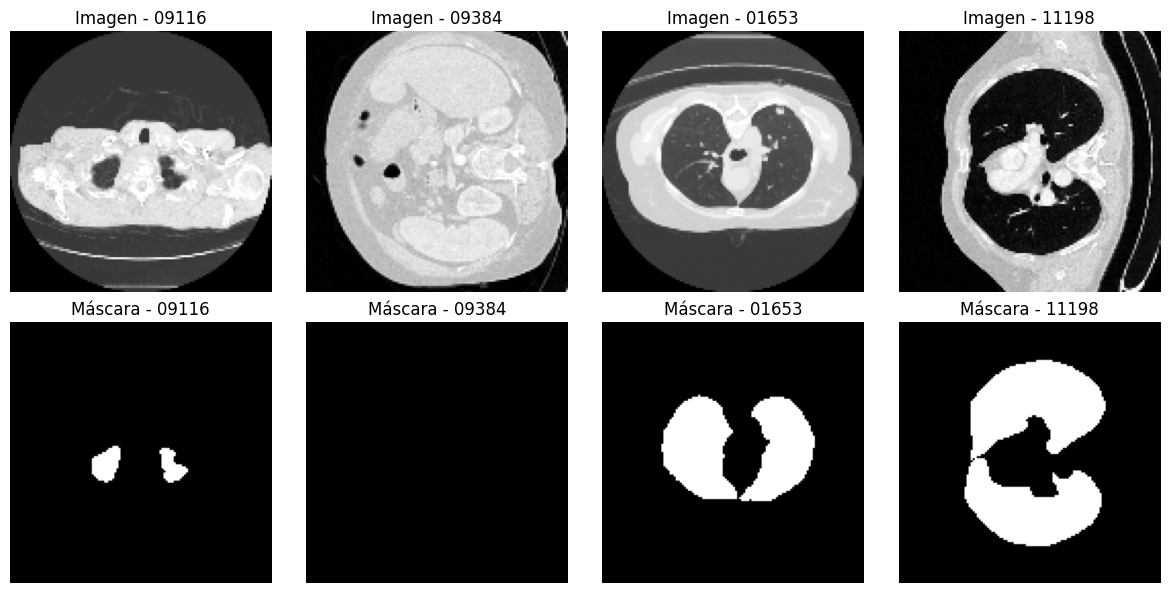

In [21]:
images, masks, infos = next(iter(train_loader))

num_examples = min(4, images.shape[0])

plt.figure(figsize=(12, 6))
for i in range(num_examples):
    # La imagen está en formato [1, H, W], convertimos a [H, W]
    img = images[i].squeeze().cpu().numpy()
    mask = masks[i].squeeze().cpu().numpy()

    # Mostrar imagen
    plt.subplot(2, num_examples, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Imagen - {infos['img_id'][i]}")
    plt.axis('off')

    # Mostrar máscara
    plt.subplot(2, num_examples, i + 1 + num_examples)
    plt.imshow(mask, cmap='gray')
    plt.title(f"Máscara - {infos['img_id'][i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [22]:
try:
  sample_batch = next(iter(train_loader))
  print(f"   Batch de prueba exitoso - Forma: {sample_batch[0].shape}")
except Exception as e:
  print(f"   Error en batch de prueba: {e}")

   Batch de prueba exitoso - Forma: torch.Size([16, 1, 128, 128])


In [23]:
def train_epoch(config, train_loader, model, criterion, optimizer, epoch):
  """Entrena el modelo por una época"""
  avg_meters = {'loss': AverageMeter(), 'iou': AverageMeter()}
  
  model.train()
  pbar = tqdm(total=len(train_loader), desc=f'Epoch {epoch}')
  
  # Gradient accumulation
  accumulation_steps = max(1, config['accumulation_steps'] // config['batch_size'])
  optimizer.zero_grad()
  
  for i, (input, target, *_) in enumerate(train_loader):
    input = input.cuda()
    target = target.cuda()
    
    if i == 0:
      with profile(
        activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
        record_shapes=True,
        profile_memory=True,
        with_flops=True
      ) as prof:
        with record_function("model_training_step"):
          # Normalizar target si es necesario
          if target.max() > 1.0:
            target = target.float() / 255.0

          if config['deep_supervision']:
            outputs = model(input)
            loss = 0
            for j, output in enumerate(outputs):
              weight = 1.0 / (2 ** j)
              loss += weight * criterion(output, target)
            loss /= sum([1.0 / (2 ** j) for j in range(len(outputs))])
            iou = iou_score(outputs[-1], target)
          else:
            output = model(input)
            loss = criterion(output, target)
            iou = iou_score(output, target)

          loss = loss / accumulation_steps
          loss.backward()
      print("\n[torch.profiler] Métricas primer batch:")
      print(prof.key_averages().table(sort_by="cuda_memory_usage", row_limit=8))
      print(prof.key_averages().table(sort_by="self_cuda_time_total", row_limit=8))
      try:
        print(prof.key_averages().table(sort_by="flops", row_limit=8))
      except Exception:
        print("FLOPs no disponibles (requiere PyTorch >= 2.0 y soporte experimental).")
      continue
    
    # Normalizar target si es necesario
    if target.max() > 1.0:
      target = target.float() / 255.0
    
    # Forward pass
    if config['deep_supervision']:
      outputs = model(input)
      loss = 0
      for j, output in enumerate(outputs):
        weight = 1.0 / (2 ** j)
        loss += weight * criterion(output, target)
      loss /= sum([1.0 / (2 ** j) for j in range(len(outputs))])
      iou = iou_score(outputs[-1], target)
    else:
      output = model(input)
      loss = criterion(output, target)
      iou = iou_score(output, target)
    
    loss = loss / accumulation_steps
    loss.backward()
    
    if (i + 1) % accumulation_steps == 0 or (i + 1) == len(train_loader):
      torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
      optimizer.step()
      optimizer.zero_grad()
    
    avg_meters['loss'].update(loss.item() * accumulation_steps, input.size(0))
    avg_meters['iou'].update(iou, input.size(0))
    
    pbar.set_postfix({
      'loss': f"{avg_meters['loss'].avg:.4f}",
      'iou': f"{avg_meters['iou'].avg:.4f}"
    })
    pbar.update(1)
  
  pbar.close()
  return OrderedDict([('loss', avg_meters['loss'].avg), ('iou', avg_meters['iou'].avg)])

def validate_epoch(config, val_loader, model, criterion):
  """Valida el modelo"""
  avg_meters = {'loss': AverageMeter(), 'iou': AverageMeter()}
  
  model.eval()
  
  with torch.no_grad():
    pbar = tqdm(total=len(val_loader), desc='Validation')
    for input, target, *_ in val_loader:
      input = input.cuda()
      target = target.cuda()
      
      if target.max() > 1.0:
        target = target / 255.0
      
      if config['deep_supervision']:
        outputs = model(input)
        loss = 0
        for output in outputs:
          loss += criterion(output, target)
        loss /= len(outputs)
        iou = iou_score(outputs[-1], target)
      else:
        output = model(input)
        loss = criterion(output, target)
        iou = iou_score(output, target)
      
      avg_meters['loss'].update(loss.item(), input.size(0))
      avg_meters['iou'].update(iou, input.size(0))
      
      pbar.set_postfix({
        'val_loss': f"{avg_meters['loss'].avg:.4f}",
        'val_iou': f"{avg_meters['iou'].avg:.4f}"
      })
      pbar.update(1)
    pbar.close()
  
  return OrderedDict([('loss', avg_meters['loss'].avg), ('iou', avg_meters['iou'].avg)])

print("Funciones de entrenamiento y validación definidas")

Funciones de entrenamiento y validación definidas


In [24]:
def plot_training_progress(log, save_path=None):
  """Visualiza el progreso del entrenamiento"""
  fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
  
  epochs = log['epoch']
  
  # Loss
  ax1.plot(epochs, log['loss'], 'b-', label='Train Loss', linewidth=2)
  ax1.plot(epochs, log['val_loss'], 'r-', label='Val Loss', linewidth=2)
  ax1.set_title('Training and Validation Loss')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Loss')
  ax1.legend()
  ax1.grid(True, alpha=0.3)
  
  # IoU
  ax2.plot(epochs, log['iou'], 'b-', label='Train IoU', linewidth=2)
  ax2.plot(epochs, log['val_iou'], 'r-', label='Val IoU', linewidth=2)
  ax2.set_title('Training and Validation IoU')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('IoU')
  ax2.legend()
  ax2.grid(True, alpha=0.3)
  
  # Learning Rate
  ax3.plot(epochs, log['lr'], 'g-', linewidth=2)
  ax3.set_title('Learning Rate Schedule')
  ax3.set_xlabel('Epoch')
  ax3.set_ylabel('Learning Rate')
  ax3.set_yscale('log')
  ax3.grid(True, alpha=0.3)
  
  # Overfitting Detection
  iou_gap = [train - val for train, val in zip(log['iou'], log['val_iou'])]
  ax4.plot(epochs, iou_gap, 'purple', linewidth=2)
  ax4.axhline(y=0.08, color='red', linestyle='--', alpha=0.7, label='Overfitting Threshold')
  ax4.set_title('Overfitting Detection (Train IoU - Val IoU)')
  ax4.set_xlabel('Epoch')
  ax4.set_ylabel('IoU Gap')
  ax4.legend()
  ax4.grid(True, alpha=0.3)
  
  plt.tight_layout()
  
  if save_path:
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
  
  plt.show()

print("Función de visualización definida")

Función de visualización definida


In [25]:
log = OrderedDict([
  ('epoch', []),
  ('lr', []),
  ('loss', []),
  ('iou', []),
  ('val_loss', []),
  ('val_iou', []),
])

best_iou = 0
early_stopping = EarlyStopping(patience=config['early_stopping'], min_delta=0.001)

print("INICIANDO ENTRENAMIENTO")
print("=" * 60)

INICIANDO ENTRENAMIENTO


In [26]:
EPOCHS_TO_RUN = 100

current_epoch = len(log['epoch'])
end_epoch = min(current_epoch + EPOCHS_TO_RUN, config['epochs'])

for epoch in range(current_epoch, end_epoch):
  print(f'\nÉpoca [{epoch + 1}/{config["epochs"]}]')
  
  # Entrenamiento
  train_log = train_epoch(config, train_loader, model, criterion, optimizer, epoch)
  
  # Validación
  val_log = validate_epoch(config, val_loader, model, criterion)
  
  # Mostrar imágenes
  # model.eval()
  # with torch.no_grad():
  #   sample = next(iter(val_loader))
  #   input, target = sample[0].cuda(), sample[1].cuda()
  #   output = model(input)

  #   if isinstance(output, list):
  #       output = output[-1]

  #   output = torch.sigmoid(output)
  #   pred = (output > 0.5).float()

  #   idx = random.randint(0, input.size(0) - 1)

  # plt.figure(figsize=(12, 4))
  # plt.subplot(1, 3, 1)
  # plt.imshow(input[idx, 0].cpu(), cmap='gray')
  # plt.title(f'Input (Epoch {epoch + 1})')

  # plt.subplot(1, 3, 2)
  # plt.imshow(target[idx, 0].cpu(), cmap='gray')
  # plt.title('Target')

  # plt.subplot(1, 3, 3)
  # plt.imshow(pred[idx, 0].cpu(), cmap='gray')
  # plt.title('Predicción')
  # plt.tight_layout()
  # plt.show()

  # Actualizar scheduler
  if config['scheduler'] == 'CosineAnnealingLR':
    scheduler.step()
  elif config['scheduler'] == 'ReduceLROnPlateau':
    scheduler.step(val_log['loss'])
  
  # Mostrar resultados
  current_lr = optimizer.param_groups[0]['lr']
  print(f'Loss: {train_log["loss"]:.4f} | IoU: {train_log["iou"]:.4f} | '
        f'Val Loss: {val_log["loss"]:.4f} | Val IoU: {val_log["iou"]:.4f} | LR: {current_lr:.2e}')
  
  # Detección temprana de overfitting
  overfitting_gap = train_log['iou'] - val_log['iou']
  loss_gap = val_log['loss'] - train_log['loss']
  
  if overfitting_gap > 0.08 and loss_gap > 0.1:
    print(f'OVERFITTING DETECTADO - IoU gap: {overfitting_gap:.4f}, Loss gap: {loss_gap:.4f}')
    for param_group in optimizer.param_groups:
      param_group['lr'] *= 0.5
    print(f'Learning rate reducido a: {optimizer.param_groups[0]["lr"]:.6f}')
  
  # Actualizar log
  log['epoch'].append(epoch)
  log['lr'].append(current_lr)
  log['loss'].append(train_log['loss'])
  log['iou'].append(train_log['iou'])
  log['val_loss'].append(val_log['loss'])
  log['val_iou'].append(val_log['iou'])
  
  # Guardar log
  pd.DataFrame(log).to_csv(f'models/{config["name"]}/log.csv', index=False)
  
  # Guardar mejor modelo
  if val_log['iou'] > best_iou:
    best_iou = val_log['iou']
    best_model_path = f'models/{config["name"]}/best_model.pth'
    torch.save(model.state_dict(), best_model_path)
    print(f'Mejor modelo guardado en {best_model_path} (IoU: {best_iou:.4f})')

  # Guardar modelo de esta época
  epoch_model_path = f'models/{config["name"]}/checkpoints/model_epoch_{epoch + 1}.pth'
  os.makedirs(os.path.dirname(epoch_model_path), exist_ok=True)
  torch.save(model.state_dict(), epoch_model_path)
  print(f'Modelo de la época {epoch + 1} guardado en {epoch_model_path}')
  
  # Early stopping
  if early_stopping(val_log['iou'], model):
    print("Early stopping activado")
    break
  
  # Limpiar memoria
  torch.cuda.empty_cache()

print(f"\nEntrenamiento completado hasta época {epoch}")
print(f"Mejor IoU alcanzado: {best_iou:.4f}")


Época [1/100]


Epoch 0:   0%|          | 0/1076 [00:00<?, ?it/s]


[torch.profiler] Métricas primer batch:
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  Total MFLOPs  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                   ConvolutionBackward0         0.01%     625.900us        35.41%        2.684s      39.477ms           0 b           0 b       1.92 Gb           0 b            68            --  
                             aten::convolution_backward        35.36%        2.681s        35.40%        2.684

Validation: 100%|██████████| 295/295 [00:22<00:00, 12.84it/s, val_loss=0.3222, val_iou=0.7592]


Loss: 0.1936 | IoU: 0.7416 | Val Loss: 0.3222 | Val IoU: 0.7592 | LR: 5.00e-04
Mejor modelo guardado en models/processed_data_512_NestedUNet_binary_wDS/best_model.pth (IoU: 0.7592)
Modelo de la época 1 guardado en models/processed_data_512_NestedUNet_binary_wDS/checkpoints/model_epoch_1.pth

Época [2/100]


Epoch 1:   0%|          | 0/1076 [00:00<?, ?it/s]


[torch.profiler] Métricas primer batch:
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  Total MFLOPs  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                   ConvolutionBackward0         0.11%     307.000us         2.28%       6.239ms      91.750us           0 b           0 b       1.92 Gb           0 b            68            --  
                             aten::convolution_backward         1.60%       4.375ms         2.17%       5.932m

Epoch 1:   0%|          | 0/1076 [00:07<?, ?it/s, loss=0.0275, iou=0.8934]

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  Total MFLOPs  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                           aten::conv2d         0.10%     269.500us         3.39%       9.267ms     136.285us           0 b           0 b     725.89 Mb           0 b            68    284811.067  
                                              aten::mul         1.81%       4.964ms         1.81%       4.964ms      34.717us           0 b           0

Validation: 100%|██████████| 295/295 [00:20<00:00, 14.08it/s, val_loss=0.2264, val_iou=0.8874]


Loss: 0.0331 | IoU: 0.8407 | Val Loss: 0.2264 | Val IoU: 0.8874 | LR: 5.00e-04
Mejor modelo guardado en models/processed_data_512_NestedUNet_binary_wDS/best_model.pth (IoU: 0.8874)
Modelo de la época 2 guardado en models/processed_data_512_NestedUNet_binary_wDS/checkpoints/model_epoch_2.pth

Época [3/100]


Epoch 2:   0%|          | 0/1076 [00:00<?, ?it/s]


[torch.profiler] Métricas primer batch:
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  Total MFLOPs  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                   ConvolutionBackward0         0.06%     296.200us         1.40%       6.595ms      96.985us           0 b           0 b       1.92 Gb           0 b            68            --  
                             aten::convolution_backward         0.99%       4.685ms         1.33%       6.299m

Validation: 100%|██████████| 295/295 [00:20<00:00, 14.34it/s, val_loss=0.2035, val_iou=0.9057]


Loss: 0.0286 | IoU: 0.8467 | Val Loss: 0.2035 | Val IoU: 0.9057 | LR: 4.99e-04
Mejor modelo guardado en models/processed_data_512_NestedUNet_binary_wDS/best_model.pth (IoU: 0.9057)
Modelo de la época 3 guardado en models/processed_data_512_NestedUNet_binary_wDS/checkpoints/model_epoch_3.pth

Época [4/100]


Epoch 3:   0%|          | 0/1076 [00:00<?, ?it/s]


[torch.profiler] Métricas primer batch:
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  Total MFLOPs  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                   ConvolutionBackward0         0.07%     296.700us         1.60%       6.861ms     100.900us           0 b           0 b       1.92 Gb           0 b            68            --  
                             aten::convolution_backward         1.14%       4.890ms         1.53%       6.564m

Validation: 100%|██████████| 295/295 [00:20<00:00, 14.28it/s, val_loss=0.2100, val_iou=0.8552]


Loss: 0.0265 | IoU: 0.8528 | Val Loss: 0.2100 | Val IoU: 0.8552 | LR: 4.98e-04
Modelo de la época 4 guardado en models/processed_data_512_NestedUNet_binary_wDS/checkpoints/model_epoch_4.pth

Época [5/100]


Epoch 4:   0%|          | 0/1076 [00:00<?, ?it/s]


[torch.profiler] Métricas primer batch:
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  Total MFLOPs  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                   ConvolutionBackward0         0.08%     339.100us         1.87%       8.103ms     119.154us           0 b           0 b       1.92 Gb           0 b            68            --  
                             aten::convolution_backward         1.46%       6.326ms         1.79%       7.763m

Validation: 100%|██████████| 295/295 [00:20<00:00, 14.26it/s, val_loss=0.2202, val_iou=0.8058]


Loss: 0.0245 | IoU: 0.8574 | Val Loss: 0.2202 | Val IoU: 0.8058 | LR: 4.97e-04
Modelo de la época 5 guardado en models/processed_data_512_NestedUNet_binary_wDS/checkpoints/model_epoch_5.pth

Época [6/100]


Epoch 5:   0%|          | 0/1076 [00:00<?, ?it/s]


[torch.profiler] Métricas primer batch:
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  Total MFLOPs  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                   ConvolutionBackward0         0.08%     296.800us         1.95%       7.558ms     111.143us           0 b           0 b       1.92 Gb           0 b            68            --  
                             aten::convolution_backward         1.40%       5.445ms         1.87%       7.261m

Epoch 5:   0%|          | 0/1076 [00:06<?, ?it/s, loss=0.0250, iou=0.7387]

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  Total MFLOPs  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                           aten::conv2d         0.07%     277.800us         2.17%       8.432ms     123.994us           0 b           0 b     725.89 Mb           0 b            68    284811.067  
                                              aten::mul        21.47%      83.408ms        21.47%      83.408ms     583.276us           0 b           0

Validation: 100%|██████████| 295/295 [00:20<00:00, 14.38it/s, val_loss=0.2189, val_iou=0.8741]


Loss: 0.0235 | IoU: 0.8638 | Val Loss: 0.2189 | Val IoU: 0.8741 | LR: 4.96e-04
Modelo de la época 6 guardado en models/processed_data_512_NestedUNet_binary_wDS/checkpoints/model_epoch_6.pth

Época [7/100]


Epoch 6:   0%|          | 0/1076 [00:00<?, ?it/s]


[torch.profiler] Métricas primer batch:
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  Total MFLOPs  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                   ConvolutionBackward0         0.07%     307.000us         1.59%       7.240ms     106.463us           0 b           0 b       1.92 Gb           0 b            68            --  
                             aten::convolution_backward         1.16%       5.274ms         1.52%       6.932m

Validation: 100%|██████████| 295/295 [00:20<00:00, 14.41it/s, val_loss=0.2067, val_iou=0.8760]


Loss: 0.0233 | IoU: 0.8614 | Val Loss: 0.2067 | Val IoU: 0.8760 | LR: 4.94e-04
Modelo de la época 7 guardado en models/processed_data_512_NestedUNet_binary_wDS/checkpoints/model_epoch_7.pth

Época [8/100]


Epoch 7:   0%|          | 0/1076 [00:00<?, ?it/s]


[torch.profiler] Métricas primer batch:
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  Total MFLOPs  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                   ConvolutionBackward0         0.08%     267.700us         2.00%       6.511ms      95.754us           0 b           0 b       1.92 Gb           0 b            68            --  
                             aten::convolution_backward         1.46%       4.738ms         1.92%       6.244m

Validation: 100%|██████████| 295/295 [00:20<00:00, 14.34it/s, val_loss=0.3972, val_iou=0.6061]


Loss: 0.0229 | IoU: 0.8648 | Val Loss: 0.3972 | Val IoU: 0.6061 | LR: 4.92e-04
OVERFITTING DETECTADO - IoU gap: 0.2587, Loss gap: 0.3743
Learning rate reducido a: 0.000246
Modelo de la época 8 guardado en models/processed_data_512_NestedUNet_binary_wDS/checkpoints/model_epoch_8.pth

Época [9/100]


Epoch 8:   0%|          | 0/1076 [00:00<?, ?it/s]


[torch.profiler] Métricas primer batch:
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  Total MFLOPs  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                   ConvolutionBackward0         0.08%     276.400us         1.81%       6.331ms      93.107us           0 b           0 b       1.92 Gb           0 b            68            --  
                             aten::convolution_backward         1.32%       4.619ms         1.73%       6.055m

Validation: 100%|██████████| 295/295 [00:20<00:00, 14.32it/s, val_loss=0.1980, val_iou=0.8803]


Loss: 0.0202 | IoU: 0.8836 | Val Loss: 0.1980 | Val IoU: 0.8803 | LR: 2.45e-04
Modelo de la época 9 guardado en models/processed_data_512_NestedUNet_binary_wDS/checkpoints/model_epoch_9.pth

Época [10/100]


Epoch 9:   0%|          | 0/1076 [00:00<?, ?it/s]


[torch.profiler] Métricas primer batch:
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  Total MFLOPs  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                   ConvolutionBackward0         0.07%     312.000us         1.40%       6.013ms      88.428us           0 b           0 b       1.92 Gb           0 b            68            --  
                             aten::convolution_backward         0.99%       4.255ms         1.33%       5.701m

Epoch 9:   0%|          | 0/1076 [00:06<?, ?it/s, loss=0.0189, iou=0.9385]

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  Total MFLOPs  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                           aten::conv2d         0.06%     242.800us         1.68%       7.186ms     105.678us           0 b           0 b     725.89 Mb           0 b            68    284811.067  
                                              aten::mul         1.07%       4.609ms         1.07%       4.609ms      32.229us           0 b           0

Validation: 100%|██████████| 295/295 [00:20<00:00, 14.44it/s, val_loss=0.7703, val_iou=0.1029]


Loss: 0.0201 | IoU: 0.8831 | Val Loss: 0.7703 | Val IoU: 0.1029 | LR: 2.44e-04
OVERFITTING DETECTADO - IoU gap: 0.7801, Loss gap: 0.7502
Learning rate reducido a: 0.000122
Modelo de la época 10 guardado en models/processed_data_512_NestedUNet_binary_wDS/checkpoints/model_epoch_10.pth

Época [11/100]


Epoch 10:   0%|          | 0/1076 [00:00<?, ?it/s]


[torch.profiler] Métricas primer batch:
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  Total MFLOPs  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                   ConvolutionBackward0         0.09%     269.900us         2.11%       6.455ms      94.931us           0 b           0 b       1.92 Gb           0 b            68            --  
                             aten::convolution_backward         1.55%       4.737ms         2.02%       6.185m

Epoch 10:   0%|          | 1/1076 [00:06<2:02:49,  6.86s/it, loss=0.0687, iou=0.7481]

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  Total MFLOPs  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                           aten::conv2d         0.08%     253.900us         2.45%       7.501ms     110.313us           0 b           0 b     725.89 Mb           0 b            68    284811.067  
                                              aten::mul         1.59%       4.855ms         1.59%       4.855ms      33.952us           0 b           0

Validation: 100%|██████████| 295/295 [00:20<00:00, 14.38it/s, val_loss=0.2169, val_iou=0.8917]


Loss: 0.0185 | IoU: 0.8931 | Val Loss: 0.2169 | Val IoU: 0.8917 | LR: 1.21e-04
Modelo de la época 11 guardado en models/processed_data_512_NestedUNet_binary_wDS/checkpoints/model_epoch_11.pth

Época [12/100]


Epoch 11:   0%|          | 0/1076 [00:00<?, ?it/s]


[torch.profiler] Métricas primer batch:
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  Total MFLOPs  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                   ConvolutionBackward0         0.08%     283.700us         1.94%       6.509ms      95.722us           0 b           0 b       1.92 Gb           0 b            68            --  
                             aten::convolution_backward         1.42%       4.770ms         1.86%       6.225m

Validation: 100%|██████████| 295/295 [00:20<00:00, 14.45it/s, val_loss=0.1846, val_iou=0.9003]


Loss: 0.0185 | IoU: 0.8960 | Val Loss: 0.1846 | Val IoU: 0.9003 | LR: 1.21e-04
Modelo de la época 12 guardado en models/processed_data_512_NestedUNet_binary_wDS/checkpoints/model_epoch_12.pth

Época [13/100]


Epoch 12:   0%|          | 0/1076 [00:00<?, ?it/s]


[torch.profiler] Métricas primer batch:
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  Total MFLOPs  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                   ConvolutionBackward0         0.08%     269.800us         1.80%       6.292ms      92.526us           0 b           0 b       1.92 Gb           0 b            68            --  
                             aten::convolution_backward         1.31%       4.593ms         1.72%       6.022m

Validation: 100%|██████████| 295/295 [00:20<00:00, 14.35it/s, val_loss=0.1924, val_iou=0.9162]


Loss: 0.0184 | IoU: 0.8976 | Val Loss: 0.1924 | Val IoU: 0.9162 | LR: 1.20e-04
Mejor modelo guardado en models/processed_data_512_NestedUNet_binary_wDS/best_model.pth (IoU: 0.9162)
Modelo de la época 13 guardado en models/processed_data_512_NestedUNet_binary_wDS/checkpoints/model_epoch_13.pth

Época [14/100]


Epoch 13:   0%|          | 0/1076 [00:00<?, ?it/s]


[torch.profiler] Métricas primer batch:
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  Total MFLOPs  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                   ConvolutionBackward0         0.07%     314.000us         1.47%       6.423ms      94.451us           0 b           0 b       1.92 Gb           0 b            68            --  
                             aten::convolution_backward         1.06%       4.624ms         1.40%       6.109m

Epoch 13:   0%|          | 1/1076 [00:07<2:06:02,  7.04s/it, loss=0.0165, iou=0.8704]

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  Total MFLOPs  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                           aten::conv2d         0.06%     253.800us         1.79%       7.840ms     115.290us           0 b           0 b     727.89 Mb           0 b            68    284811.067  
                                              aten::mul        17.63%      77.119ms        17.63%      77.119ms     539.294us           0 b           0

Validation: 100%|██████████| 295/295 [00:20<00:00, 14.44it/s, val_loss=0.1802, val_iou=0.9339]


Loss: 0.0183 | IoU: 0.8970 | Val Loss: 0.1802 | Val IoU: 0.9339 | LR: 1.19e-04
Mejor modelo guardado en models/processed_data_512_NestedUNet_binary_wDS/best_model.pth (IoU: 0.9339)
Modelo de la época 14 guardado en models/processed_data_512_NestedUNet_binary_wDS/checkpoints/model_epoch_14.pth

Época [15/100]


Epoch 14:   0%|          | 0/1076 [00:00<?, ?it/s]


[torch.profiler] Métricas primer batch:
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  Total MFLOPs  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                   ConvolutionBackward0         0.07%     274.500us         1.78%       6.567ms      96.568us           0 b           0 b       1.92 Gb           0 b            68            --  
                             aten::convolution_backward         1.30%       4.812ms         1.70%       6.292m

Validation: 100%|██████████| 295/295 [00:20<00:00, 14.47it/s, val_loss=0.1994, val_iou=0.9009]


Loss: 0.0184 | IoU: 0.8975 | Val Loss: 0.1994 | Val IoU: 0.9009 | LR: 1.18e-04
Modelo de la época 15 guardado en models/processed_data_512_NestedUNet_binary_wDS/checkpoints/model_epoch_15.pth

Época [16/100]


Epoch 15:   0%|          | 0/1076 [00:00<?, ?it/s]


[torch.profiler] Métricas primer batch:
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  Total MFLOPs  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                   ConvolutionBackward0         0.07%     256.200us         1.72%       6.008ms      88.349us           0 b           0 b       1.92 Gb           0 b            68            --  
                             aten::convolution_backward         1.25%       4.381ms         1.65%       5.752m

Epoch 15:   0%|          | 0/1076 [00:06<?, ?it/s, loss=0.0162, iou=0.9521]

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  Total MFLOPs  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                           aten::conv2d         0.08%     268.700us         9.47%      33.067ms     486.287us           0 b           0 b     726.89 Mb           0 b            68    284811.067  
                                              aten::mul         1.51%       5.289ms         1.51%       5.289ms      36.987us           0 b           0

Validation: 100%|██████████| 295/295 [00:20<00:00, 14.40it/s, val_loss=0.1861, val_iou=0.9073]


Loss: 0.0183 | IoU: 0.8980 | Val Loss: 0.1861 | Val IoU: 0.9073 | LR: 1.17e-04
Modelo de la época 16 guardado en models/processed_data_512_NestedUNet_binary_wDS/checkpoints/model_epoch_16.pth

Época [17/100]


Epoch 16:   0%|          | 0/1076 [00:00<?, ?it/s]


[torch.profiler] Métricas primer batch:
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  Total MFLOPs  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                   ConvolutionBackward0         0.07%     269.300us         1.77%       6.651ms      97.807us           0 b           0 b       1.92 Gb           0 b            68            --  
                             aten::convolution_backward         1.31%       4.911ms         1.70%       6.382m

Validation: 100%|██████████| 295/295 [00:20<00:00, 14.45it/s, val_loss=0.1849, val_iou=0.9366]


Loss: 0.0182 | IoU: 0.8991 | Val Loss: 0.1849 | Val IoU: 0.9366 | LR: 1.16e-04
Mejor modelo guardado en models/processed_data_512_NestedUNet_binary_wDS/best_model.pth (IoU: 0.9366)
Modelo de la época 17 guardado en models/processed_data_512_NestedUNet_binary_wDS/checkpoints/model_epoch_17.pth

Época [18/100]


Epoch 17:   0%|          | 0/1076 [00:00<?, ?it/s]


[torch.profiler] Métricas primer batch:
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  Total MFLOPs  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                   ConvolutionBackward0         0.07%     305.300us         1.38%       6.105ms      89.775us           0 b           0 b       1.92 Gb           0 b            68            --  
                             aten::convolution_backward         1.00%       4.424ms         1.31%       5.799m

Validation: 100%|██████████| 295/295 [00:20<00:00, 14.33it/s, val_loss=0.1919, val_iou=0.9294]


Loss: 0.0184 | IoU: 0.9000 | Val Loss: 0.1919 | Val IoU: 0.9294 | LR: 1.15e-04
Modelo de la época 18 guardado en models/processed_data_512_NestedUNet_binary_wDS/checkpoints/model_epoch_18.pth

Época [19/100]


Epoch 18:   0%|          | 0/1076 [00:00<?, ?it/s]


[torch.profiler] Métricas primer batch:
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  Total MFLOPs  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                   ConvolutionBackward0         0.06%     269.500us         1.38%       5.998ms      88.213us           0 b           0 b       1.92 Gb           0 b            68            --  
                             aten::convolution_backward         0.99%       4.311ms         1.32%       5.729m

Validation: 100%|██████████| 295/295 [00:20<00:00, 14.35it/s, val_loss=0.1878, val_iou=0.9285]


Loss: 0.0180 | IoU: 0.9014 | Val Loss: 0.1878 | Val IoU: 0.9285 | LR: 1.14e-04
Modelo de la época 19 guardado en models/processed_data_512_NestedUNet_binary_wDS/checkpoints/model_epoch_19.pth

Época [20/100]


Epoch 19:   0%|          | 0/1076 [00:00<?, ?it/s]


[torch.profiler] Métricas primer batch:
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  Total MFLOPs  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                   ConvolutionBackward0         0.09%     265.300us         2.05%       6.267ms      92.154us           0 b           0 b       1.92 Gb           0 b            68            --  
                             aten::convolution_backward         1.50%       4.584ms         1.96%       6.001m

Epoch 19:   0%|          | 0/1076 [00:06<?, ?it/s, loss=0.0144, iou=0.8485]

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  Total MFLOPs  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                           aten::conv2d         0.09%     261.100us         2.77%       8.462ms     124.441us           0 b           0 b     727.89 Mb           0 b            68    284811.067  
                                              aten::mul         1.62%       4.967ms         1.62%       4.967ms      34.735us           0 b           0

Validation: 100%|██████████| 295/295 [00:20<00:00, 14.36it/s, val_loss=0.2021, val_iou=0.9142]


Loss: 0.0180 | IoU: 0.9015 | Val Loss: 0.2021 | Val IoU: 0.9142 | LR: 1.13e-04
Modelo de la época 20 guardado en models/processed_data_512_NestedUNet_binary_wDS/checkpoints/model_epoch_20.pth

Época [21/100]


Epoch 20:   0%|          | 0/1076 [00:00<?, ?it/s]


[torch.profiler] Métricas primer batch:
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  Total MFLOPs  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                   ConvolutionBackward0         0.08%     291.800us         1.86%       6.786ms      99.787us           0 b           0 b       1.92 Gb           0 b            68            --  
                             aten::convolution_backward         1.37%       5.013ms         1.78%       6.494m

Epoch 20:   0%|          | 0/1076 [00:07<?, ?it/s, loss=0.0129, iou=0.9383]

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  Total MFLOPs  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                           aten::conv2d         0.07%     259.100us         2.13%       7.768ms     114.232us           0 b           0 b     727.89 Mb           0 b            68    284811.067  
                                              aten::mul         1.26%       4.595ms         1.26%       4.595ms      32.131us           0 b           0

Validation: 100%|██████████| 295/295 [00:20<00:00, 14.37it/s, val_loss=0.1952, val_iou=0.9041]


Loss: 0.0179 | IoU: 0.9008 | Val Loss: 0.1952 | Val IoU: 0.9041 | LR: 1.12e-04
Modelo de la época 21 guardado en models/processed_data_512_NestedUNet_binary_wDS/checkpoints/model_epoch_21.pth

Época [22/100]


Epoch 21:   0%|          | 0/1076 [00:00<?, ?it/s]


[torch.profiler] Métricas primer batch:
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  Total MFLOPs  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                   ConvolutionBackward0         0.07%     267.600us         1.65%       6.424ms      94.472us           0 b           0 b       1.92 Gb           0 b            68            --  
                             aten::convolution_backward         1.21%       4.717ms         1.58%       6.157m

Validation: 100%|██████████| 295/295 [00:20<00:00, 14.46it/s, val_loss=0.1900, val_iou=0.9141]


Loss: 0.0180 | IoU: 0.8988 | Val Loss: 0.1900 | Val IoU: 0.9141 | LR: 1.11e-04
Modelo de la época 22 guardado en models/processed_data_512_NestedUNet_binary_wDS/checkpoints/model_epoch_22.pth

Época [23/100]


Epoch 22:   0%|          | 0/1076 [00:00<?, ?it/s]


[torch.profiler] Métricas primer batch:
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  Total MFLOPs  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                   ConvolutionBackward0         0.06%     249.800us         1.36%       5.635ms      82.866us           0 b           0 b       1.92 Gb           0 b            68            --  
                             aten::convolution_backward         0.98%       4.062ms         1.30%       5.385m

Epoch 22:   0%|          | 0/1076 [00:07<?, ?it/s, loss=0.0149, iou=0.8676]

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  Total MFLOPs  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                           aten::conv2d         0.08%     317.200us         1.89%       7.847ms     115.391us           0 b           0 b     727.89 Mb           0 b            68    284811.067  
                                              aten::mul         1.11%       4.606ms         1.11%       4.606ms      32.210us           0 b           0

Validation: 100%|██████████| 295/295 [00:20<00:00, 14.33it/s, val_loss=0.1864, val_iou=0.9279]


Loss: 0.0176 | IoU: 0.9015 | Val Loss: 0.1864 | Val IoU: 0.9279 | LR: 1.09e-04
Modelo de la época 23 guardado en models/processed_data_512_NestedUNet_binary_wDS/checkpoints/model_epoch_23.pth

Época [24/100]


Epoch 23:   0%|          | 0/1076 [00:00<?, ?it/s]


[torch.profiler] Métricas primer batch:
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  Total MFLOPs  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                   ConvolutionBackward0         0.09%     362.500us         1.75%       6.797ms      99.957us           0 b           0 b       1.92 Gb           0 b            68            --  
                             aten::convolution_backward         1.27%       4.924ms         1.66%       6.435m

Validation: 100%|██████████| 295/295 [00:20<00:00, 14.42it/s, val_loss=0.2030, val_iou=0.8686]


Loss: 0.0181 | IoU: 0.9019 | Val Loss: 0.2030 | Val IoU: 0.8686 | LR: 1.08e-04
Modelo de la época 24 guardado en models/processed_data_512_NestedUNet_binary_wDS/checkpoints/model_epoch_24.pth

Época [25/100]


Epoch 24:   0%|          | 0/1076 [00:00<?, ?it/s]


[torch.profiler] Métricas primer batch:
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  Total MFLOPs  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                   ConvolutionBackward0         0.06%     272.100us         1.63%       7.178ms     105.562us           0 b           0 b       1.92 Gb           0 b            68            --  
                             aten::convolution_backward         1.21%       5.311ms         1.57%       6.906m

Epoch 24:   0%|          | 1/1076 [00:07<2:05:48,  7.02s/it, loss=0.0157, iou=0.9326]

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  Total MFLOPs  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                           aten::conv2d         0.06%     251.500us         1.82%       8.012ms     117.819us           0 b           0 b     727.89 Mb           0 b            68    284811.067  
                                              aten::mul         1.11%       4.895ms         1.11%       4.895ms      34.232us           0 b           0

Validation: 100%|██████████| 295/295 [00:20<00:00, 14.30it/s, val_loss=0.1859, val_iou=0.9288]


Loss: 0.0178 | IoU: 0.9011 | Val Loss: 0.1859 | Val IoU: 0.9288 | LR: 1.07e-04
Modelo de la época 25 guardado en models/processed_data_512_NestedUNet_binary_wDS/checkpoints/model_epoch_25.pth

Época [26/100]


Epoch 25:   0%|          | 0/1076 [00:00<?, ?it/s]


[torch.profiler] Métricas primer batch:
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  Total MFLOPs  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                   ConvolutionBackward0         0.06%     277.000us         1.40%       6.440ms      94.712us           0 b           0 b       1.92 Gb           0 b            68            --  
                             aten::convolution_backward         1.03%       4.715ms         1.34%       6.163m

Validation: 100%|██████████| 295/295 [00:20<00:00, 14.36it/s, val_loss=0.1960, val_iou=0.8669]


Loss: 0.0179 | IoU: 0.9017 | Val Loss: 0.1960 | Val IoU: 0.8669 | LR: 1.05e-04
Modelo de la época 26 guardado en models/processed_data_512_NestedUNet_binary_wDS/checkpoints/model_epoch_26.pth

Época [27/100]


Epoch 26:   0%|          | 0/1076 [00:00<?, ?it/s]


[torch.profiler] Métricas primer batch:
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  Total MFLOPs  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                   ConvolutionBackward0         0.09%     260.700us         2.04%       6.206ms      91.262us           0 b           0 b       1.92 Gb           0 b            68            --  
                             aten::convolution_backward         1.48%       4.497ms         1.96%       5.945m

Validation: 100%|██████████| 295/295 [00:20<00:00, 14.38it/s, val_loss=0.1893, val_iou=0.9076]

Loss: 0.0178 | IoU: 0.9017 | Val Loss: 0.1893 | Val IoU: 0.9076 | LR: 1.04e-04
Modelo de la época 27 guardado en models/processed_data_512_NestedUNet_binary_wDS/checkpoints/model_epoch_27.pth
Early stopping activado

Entrenamiento completado hasta época 26
Mejor IoU alcanzado: 0.9366


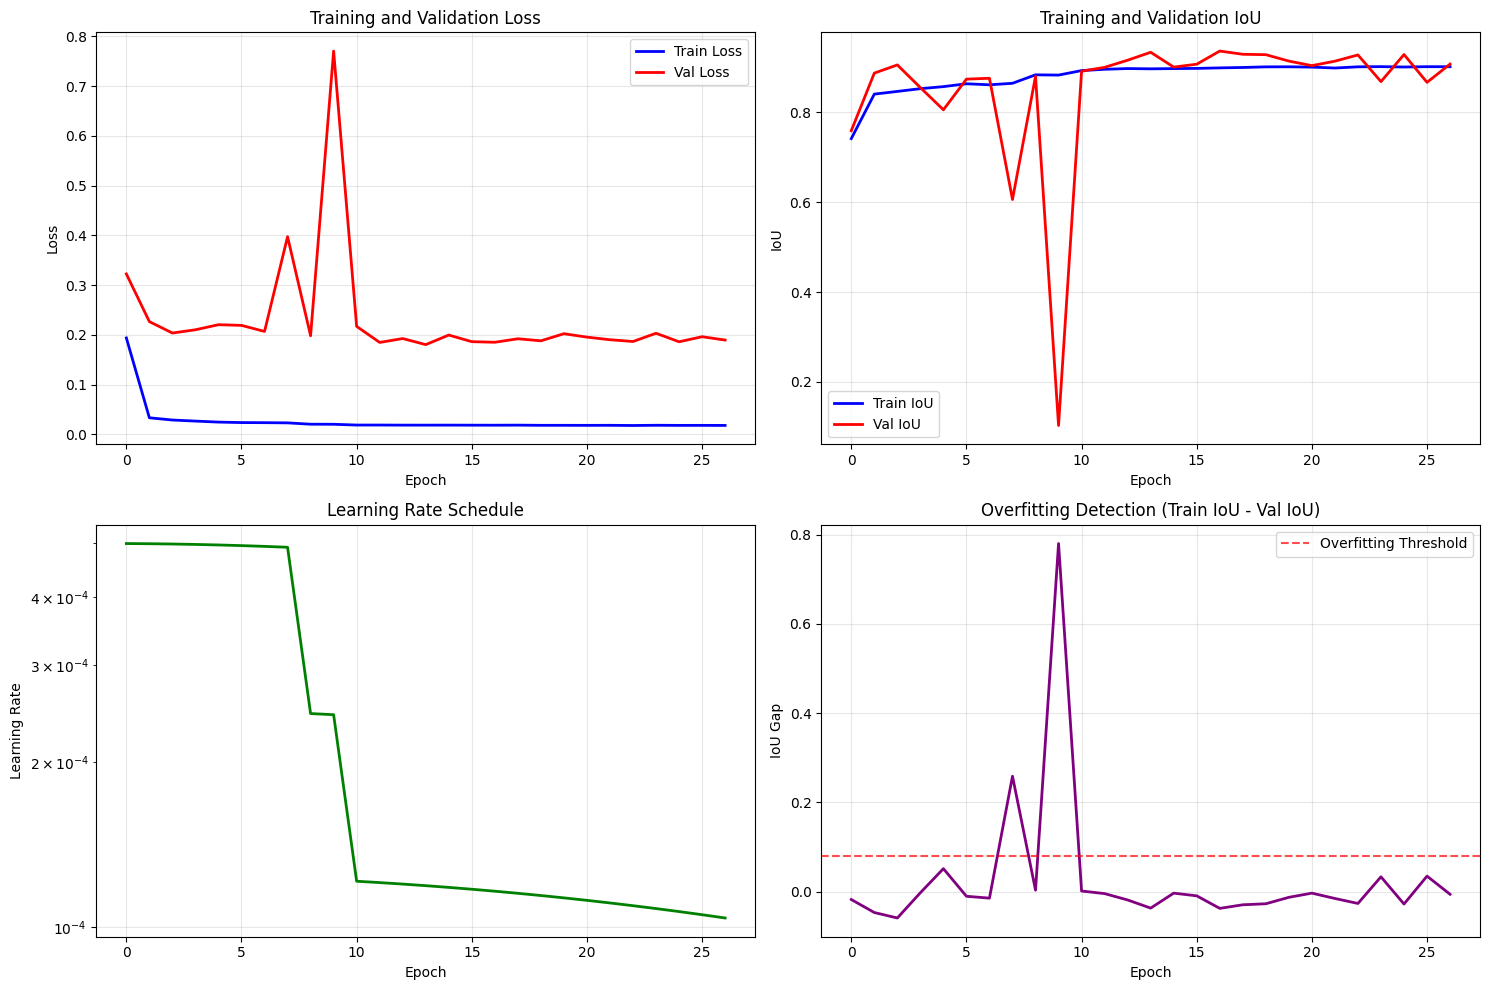

ESTADÍSTICAS DEL ENTRENAMIENTO:
----------------------------------------
Épocas completadas: 27
Mejor IoU: 0.9366
Menor Loss de validación: 0.1802
IoU actual: 0.9076
Loss actual: 0.1893
Tendencia reciente: Empeorando


In [27]:
if len(log['epoch']) > 0:
  plot_training_progress(log, f'models/{config["name"]}/training_progress.png')
  
  # Mostrar estadísticas actuales
  print("ESTADÍSTICAS DEL ENTRENAMIENTO:")
  print("-" * 40)
  print(f"Épocas completadas: {len(log['epoch'])}")
  print(f"Mejor IoU: {max(log['val_iou']):.4f}")
  print(f"Menor Loss de validación: {min(log['val_loss']):.4f}")
  print(f"IoU actual: {log['val_iou'][-1]:.4f}")
  print(f"Loss actual: {log['val_loss'][-1]:.4f}")
  
  # Detectar tendencias
  if len(log['val_iou']) >= 3:
    recent_trend = np.mean(log['val_iou'][-3:]) - np.mean(log['val_iou'][-6:-3]) if len(log['val_iou']) >= 6 else 0
    print(f"Tendencia reciente: {'Mejorando' if recent_trend > 0 else 'Empeorando' if recent_trend < 0 else 'Estable'}")
else:
  print("No hay datos de entrenamiento para visualizar. Ejecuta el bloque de entrenamiento primero.")

In [28]:
def save_checkpoint(model, optimizer, scheduler, epoch, best_iou, log, filename):
  """Guardar checkpoint completo"""
  checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
    'best_iou': best_iou,
    'log': log,
    'config': config
  }
  torch.save(checkpoint, filename)
  print(f"Checkpoint guardado: {filename}")

def load_checkpoint(filename, model, optimizer, scheduler=None):
  """Cargar checkpoint completo"""
  checkpoint = torch.load(filename)
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  if scheduler and checkpoint['scheduler_state_dict']:
      scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
  
  return (checkpoint['epoch'], checkpoint['best_iou'], 
          checkpoint['log'], checkpoint['config'])

In [29]:
if len(log['epoch']) > 0:
  checkpoint_path = f'models/{config["name"]}/checkpoint_epoch_{len(log["epoch"])}.pth'
  save_checkpoint(model, optimizer, scheduler, len(log['epoch']), best_iou, log, checkpoint_path)

print("Funciones de checkpoint definidas")

Checkpoint guardado: models/processed_data_512_NestedUNet_binary_wDS/checkpoint_epoch_27.pth
Funciones de checkpoint definidas


In [ ]:
def print_final_summary():
  """Imprime un resumen final del entrenamiento"""
  if len(log['epoch']) == 0:
    print("No hay datos de entrenamiento para resumir")
    return
  
  print("\n" + "="*60)
  print("RESUMEN FINAL DEL ENTRENAMIENTO")
  print("="*60)
  
  print(f"Configuración:")
  print(f"   • Modelo: {config['arch']}")
  print(f"   • Función de pérdida: {config['loss']}")
  print(f"   • Optimizador: {config['optimizer']} (LR: {config['lr']})")
  print(f"   • Batch size: {config['batch_size']}")
  print(f"   • Early stopping: {config['early_stopping']} épocas")
  
  print(f"\nResultados:")
  print(f"   • Épocas completadas: {len(log['epoch'])}/{config['epochs']}")
  print(f"   • Mejor IoU: {max(log['val_iou']):.4f}")
  print(f"   • IoU final: {log['val_iou'][-1]:.4f}")
  print(f"   • Mejor Loss validación: {min(log['val_loss']):.4f}")
  print(f"   • Loss final: {log['val_loss'][-1]:.4f}")
  
  # Análisis de overfitting
  final_gap = log['iou'][-1] - log['val_iou'][-1]
  print(f"\nAnálisis de Overfitting:")
  print(f"   • Gap IoU (Train-Val): {final_gap:.4f}")
  if final_gap > 0.08:
    print(f"   • Posible overfitting detectado")
  else:
    print(f"   • Nivel de overfitting aceptable")
  
  # Tendencia de mejora
  if len(log['val_iou']) >= 5:
    recent_iou = np.mean(log['val_iou'][-3:])
    early_iou = np.mean(log['val_iou'][:3])
    improvement = recent_iou - early_iou
    print(f"\nMejora Total:")
    print(f"   • IoU inicial: {early_iou:.4f}")
    print(f"   • IoU reciente: {recent_iou:.4f}")
    print(f"   • Mejora: {improvement:.4f} ({improvement/early_iou*100:.1f}%)")
  
  print(f"\nArchivos guardados:")
  print(f"   • Modelo: models/{config['name']}/model.pth")
  print(f"   • Log: models/{config['name']}/log.csv")
  print(f"   • Config: models/{config['name']}/config.yml")
  print(f"   • Gráficas: models/{config['name']}/training_progress.png")
  
  print("="*60)

# Ejecutar resumen si hay datos
print_final_summary()


RESUMEN FINAL DEL ENTRENAMIENTO
Configuración:
   • Modelo: NestedUNet
   • Función de pérdida: TverskyLoss
   • Optimizador: Adam (LR: 0.0005)
   • Batch size: 16
   • Early stopping: 10 épocas

Resultados:
   • Épocas completadas: 27/100
   • Mejor IoU: 0.9366
   • IoU final: 0.9076
   • Mejor Loss validación: 0.1802
   • Loss final: 0.1893

Análisis de Overfitting:
   • Gap IoU (Train-Val): -0.0058
   • Nivel de overfitting aceptable

Mejora Total:
   • IoU inicial: 0.8508
   • IoU reciente: 0.9011
   • Mejora: 0.0503 (5.9%)

Archivos guardados:
   • Modelo: models/processed_data_512_NestedUNet_binary_wDS/model.pth
   • Log: models/processed_data_512_NestedUNet_binary_wDS/log.csv
   • Config: models/processed_data_512_NestedUNet_binary_wDS/config.yml
   • Gráficas: models/processed_data_512_NestedUNet_binary_wDS/training_progress.png
